**BETEL**

In [1]:
from functions.functions import *

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import inv
import time

In [ ]:
from scipy.special import softmax
import numpy as np
import matplotlib.pyplot as plt
from math import *
from scipy.stats import multivariate_normal

- Try to cythonize the Newton solver and Metropolis Hasting to increase performance

# Regression data
We are not supposed to know the parameters, only alpha and beta.

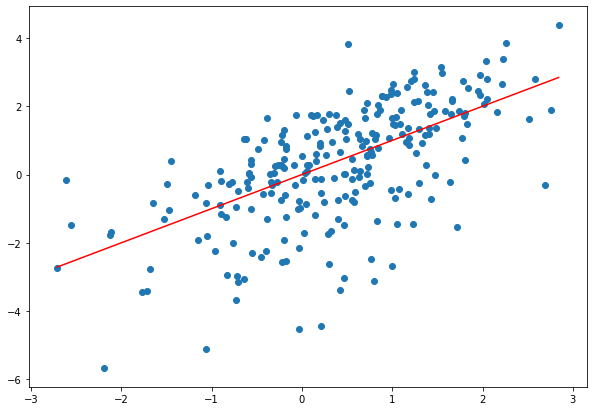

In [2]:
np.random.seed(1235)
n = 250
z, y = generate_regression(n,alpha=0,beta=1)
plt.figure(figsize = (10,7))
x = np.linspace(np.min(z),np.max(z),2)
plt.plot(x,x, c="r")
plt.scatter(z,y)
plt.show()

In [3]:
e = y-z
print(np.mean(e)) # -> 0 

# Theoretical v -> 3*mu*s^2 + mu^3
mu1 = 0.75
sigma1 = 0.75
mu2 = -0.75
sigma2 = 1.25
est = (1/2)*(3*mu1*sigma1**2 + mu1**3 + 3*mu2*sigma2**2 + mu2**3)
print(est)

# on data
print(np.mean(e**3))

-0.10736578046507142
-1.125
-2.8287859891126983


# Compute the Mode

We use a window around the true parameters to find the mode of the logETEL function but in practice we do not have access to them! We show with a heatmap/contour plot that the grid approximate the contour plot of a Gaussian distribution.

In [4]:
t = 20
alpha_s = np.linspace(-1,1,t)
beta_s = np.linspace(0,2,t)
v_s = np.linspace(-1,1,t)
res = np.zeros((t,t,t))
c=0

In [ ]:
for ix,i in enumerate(alpha_s):
    for jx,j in enumerate(beta_s):
        for lx,l in enumerate(v_s):
            x=np.array([i,j,l])
            v,_,_ =calculate_posterior(x,y,z)
            if v==None:
                continue
            res[ix,jx,lx] = v
            c+=1
            if c%50==0:
                print(c)

In [5]:
#np.save("./log/grid",res)
res=np.load("./log/grid.npy")

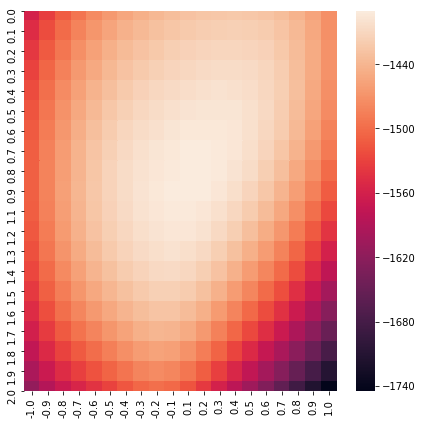

In [6]:
# Seaborn heatmap 
v_pos = 1
x_axis_labels = np.round(alpha_s,1) # labels for x-axis
y_axis_labels = np.round(beta_s,1) # labels for y-axis
plt.figure(figsize = (7,7))
sns.heatmap(res[:,:,v_pos], xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.show()

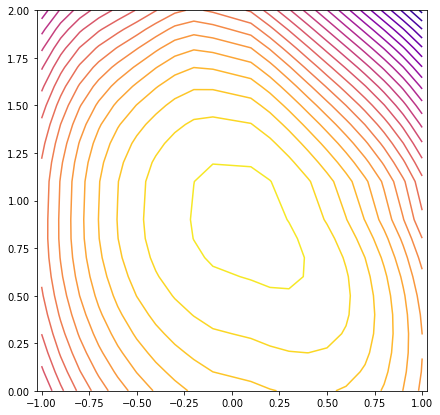

In [7]:
# Contour plot
plt.figure(figsize = (7,7))
X, Y = np.meshgrid(x_axis_labels, y_axis_labels)
plt.contour(X, Y, res[:,:,v_pos],25,cmap='plasma')
plt.axis('equal');
plt.show()

In [8]:
# Get the mode
res[res==0]=-np.infty
print(np.max(res),np.argmax(res))
a,b,c = np.unravel_index(np.argmax(res, axis=None), res.shape)
print("Mode: ", alpha_s[a], beta_s[b], v_s[c])

-1389.3839489222687 3400
Mode:  -0.1578947368421053 1.0526315789473684 -1.0


# Metropolis Hasting

In [9]:
mean = np.array([alpha_s[a], beta_s[b], v_s[c]])
cov = -inv(approx_hessian(mean[0],mean[1],mean[2],y,z))
print(mean)
print(cov)

[-0.15789474  1.05263158 -1.        ]
[[ 0.00968476 -0.00410729 -0.00561384]
 [-0.00410729  0.00803329  0.00435117]
 [-0.00561384  0.00435117  0.07488101]]


In [ ]:
tic = time.time()
sample = metropolis(10000,1000,y,z, mean, cov)
toc = time.time()
print("time: {}".format(toc-tic))

iteration number:  1
iter:  1 coeffs:  -0.22519093026913684 1.053533079872412 -0.914202426183874
iteration number:  51
iter:  51 coeffs:  -0.1389026014813836 0.9814039484176409 -1.2531899319365243
iteration number:  101
iter:  101 coeffs:  0.06940542268240207 1.0287036413810595 -1.7584892329748385
iteration number:  151
iter:  151 coeffs:  -0.10747033909407358 0.9525611380572808 -1.2785883561239741
iteration number:  201
iter:  201 coeffs:  -0.07783342102246404 1.013521751461091 -1.9399186541213873
iteration number:  251
iter:  251 coeffs:  -0.07783342102246404 1.013521751461091 -1.9399186541213873
iteration number:  301
iter:  301 coeffs:  -0.17501954574084522 1.1287596613603719 -2.800752365600652
iteration number:  351
iter:  351 coeffs:  -0.17501954574084522 1.1287596613603719 -2.800752365600652
iteration number:  401
iter:  401 coeffs:  -0.17501954574084522 1.1287596613603719 -2.800752365600652
iteration number:  451
iter:  451 coeffs:  -0.17501954574084522 1.1287596613603719 -2.80

In [21]:
np.save("./log/res_metro",sample)
sample=np.load("./log/res_metro.npy")

In [26]:
print(np.where(np.isnan(sample)))
sample2=np.delete(sample,1553,0)
print(np.mean(sample2[:,1]),np.max(sample2[:,1]),np.std(sample2[:,2]))

(array([1553, 1553, 1553]), array([0, 1, 2]))
1.1202984383500803 1.3057310759029375 0.5033305582893929


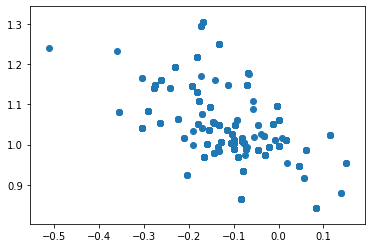

In [31]:
# belle ellipse de confiance
plt.scatter(sample2[:,0],sample2[:,1],zorder=2);

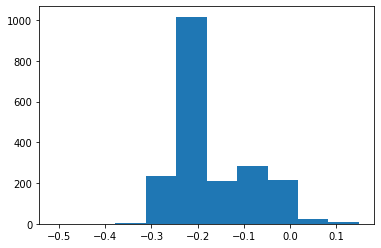

In [35]:
#belle normale
plt.hist(sample2[:,0]);

# Model Selection

In [ ]:
#généraliser le travail à des conditions de moments différentes
#creation d'une fonction de récupération du mode et de la hessienne en fonction du modele considéré

def model_hessian_model(model="M2"):
    t = 20
    alpha_s = np.linspace(-1,1,t)
    beta_s = np.linspace(0,2,t)
    v_s = np.linspace(-1,1,t)
    res = np.zeros((t,t,t))
    c=0

    for ix,i in enumerate(alpha_s):
        for jx,j in enumerate(beta_s):
            for lx,l in enumerate(v_s):
                x=np.array([i,j,l])
                v,_,_=calculate_posterior(x,y,z,model)
                if v==None:
                    continue
                res[ix,jx,lx] = v
                c+=1
                if c%50==0:
                    print(c)
    
    res[res==0]=-np.infty
    a,b,c = np.unravel_index(np.argmax(res, axis=None), res.shape)
    mean=np.array((alpha_s[a], beta_s[b],v_s[c]))
    cov = -inv(approx_hessian(mean[0],mean[1],mean[2],0.01,0.01,model)) 
    
    return(mean,cov)

def q(phi,mean,cov):
    multivariate_t_distribution(phi, mu=mean, Sigma=cov, df=3)


def log_coeff(phi,phi_tild,model,mean,cov):
    return(calculate_posterior(phi_tild,y,z,model)[0]-calculate_posterior(phi,y,z,model)[0]+np.log(q(phi,mean,cov))-np.log(q(phi_tild,mean,cov)))


In [ ]:
#step1
phi_tild,cov= model_hessian_model(model="M2") #je colle aux notations du papier mais je prends la moyenne de log posterior pour phi_tild_l (dépend du modele)
log_posterior, log_prior,log_px = calculate_posterior(phi_tild,y,z,model="M2")

#il ne manque plus que le troisieme terme de log mx 



In [ ]:
#step2
#numérateur il faut générer selon hastings et moyenniser
nburn=1000
niter1=1000
total1=0
alpha_0,beta_0,v_0=0.5,0.5,0.5 
print("phase 1")
for i in range(niter1+nburn):
    try:
        alpha_0,beta_0,v_0=iteration(alpha_0,beta_0,v_0,mean,cov)
    except:
        continue
    if i>=999:#on grille les premières générations
        print("youpi")
        gen= np.array([alpha_0,beta_0,v_0])
        total1+=exp(log_coeff(gen,phi_tild,"M2",phi_tild,cov))*q(phi_tild,phi_tild,cov)

E1=total1/niter1

print("phase 2")
#dénominateur
#génération plusieurs fois suivant q

niter2=1000
total2=0
for i in range(niter2):
    gen=multivariate_t_rvs(phi_tild, cov, df=3, n=1)[0]
    total2+=exp(log_coeff(phi_tild,gen,"M2",phi_tild,cov))
E2=total2/niter2    


In [ ]:
#Et Finalement
log_mx= log_prior+log_px-log(E1/E2)

A mettre dans l'overleaf,
la loi de proposition dépend du mode de la log etel qui elle dépend du model choisi, un peu bizarr
on veut - la hessienne, car la hessienne en le mode est définie négative donc on la rend définie positive comme ça c'est ce qu'on doit avoir pour une variance